# Raw data from policy-based self-play

We let the HeuristicPolicy play against itself to get some quick although not so high-quality training data. The policy and value evaluations stem from the heuristic policy itself.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import tensorflow as tf

from aegomoku.gomoku_game import GomokuGame
from aegomoku.gomoku_board import GomokuBoard
from aegomoku.policies.primary_detector import PrimaryDetector
from aegomoku.gomoku_game import RandomBoardInitializer
from aegomoku.policies.heuristic_policy import HeuristicPolicy
tf.config.list_physical_devices('GPU')

2022-08-28 10:50:45.801058: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:50:45.801752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:50:45.806894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:50:45.807554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:50:45.808338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
BOARD_SIZE=15
tight = HeuristicPolicy(15, .9)
loose = HeuristicPolicy(15, .4)
evaluator = HeuristicPolicy(15, 0,)
primary = PrimaryDetector(BOARD_SIZE)

# Initial board: 4 random stones in thw central square
rbi = RandomBoardInitializer(BOARD_SIZE, 4, 5, 9, 5, 9)
game = GomokuGame(BOARD_SIZE, initializer=rbi)

2022-08-20 20:58:14.929633: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-20 20:58:15.075610: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:15.076199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 20:58:15.076810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
def is_critical(state, value_threshold):
    current_player_policy = primary.call(state)[:, :, :, 3]
    other_player_policy = primary.call(state)[:, :, :, 4]
    current_max = np.max(current_player_policy, axis=None)
    other_max = np.max(other_player_policy, axis=None)
    return max(current_max, other_max) >= value_threshold

In [5]:
def create_sample(the_board: GomokuBoard):
    position = [stone.i for stone in the_board.stones]
    state = np.expand_dims(the_board.canonical_representation(), 0).astype(float)
    probs, value = evaluator.predict(state)
    probs = (np.array(probs)*255).astype(np.uint8)
    value = value.numpy()
    return position, probs, value

In [6]:
def one_game(verbose=False, value_threshold: int=0):
    game_data = []
    board = game.get_initial_board()
    players = [tight, loose]
    pointer = 0
    state = np.expand_dims(board.canonical_representation(), 0).astype(float)
    max_stones = 80
    num_stones = 0
    while tight.get_winner(state) is None and num_stones < max_stones:
        player = players[pointer]
        pointer = 1 - pointer
        num_stones += 1
        options = player.get_advisable_actions(state)
        move = random.choice(options)
        board.act(move)
        state = np.expand_dims(board.canonical_representation(), 0).astype(float)

        if tight.get_winner(state) is not None:
            break
        if is_critical(state, value_threshold):
            game_data.append(create_sample(board))
            if verbose:
                board.plot()
                print("MUST DEFEND")
    if num_stones < max_stones:
        if verbose:
            print([stone.i for stone in board.stones])
            print("GAME OVER")
    return game_data

In [67]:
data = []

In [68]:
for i in range(200):
    data += one_game(value_threshold=900)

In [69]:
from aegomoku.game_data import expand_trajectory

examples = expand_trajectory(game, BOARD_SIZE, data)
len(examples), len(examples[0]), examples[0][0].shape

(1424, 3, (17, 17, 3))

Next to play: BLACK
Value from BLACK's point of view: 0.9357343821281586


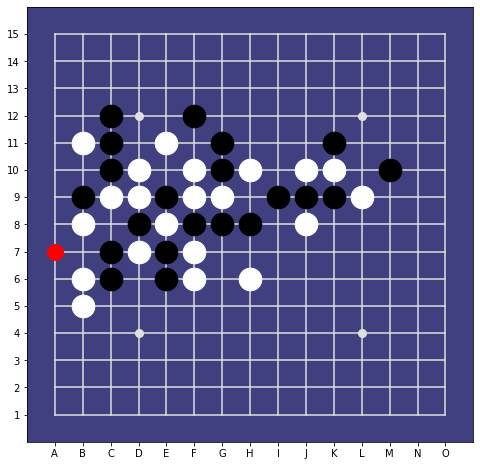

In [111]:
from aegomoku.utils import analyse_example

analyse_example(BOARD_SIZE, examples[random.randint(0, len(examples))])

---

### Saving the game data

In [3]:
filename = "trajectories/policy/loose_60000.pickle"

In [4]:
from pickle import Pickler

with open(filename, 'wb+') as f:
    Pickler(f).dump(data)

NameError: name 'data' is not defined

---

### Reading game data from the file

In [7]:
filename = "trajectories/policy/loose_60000.pickle"

In [8]:
from aegomoku.game_data import read_training_data

BOARD_SIZE=15
examples = read_training_data(filename, BOARD_SIZE)
len(examples), len(examples[0]), examples[0][0].shape

(59760, 3, (17, 17, 3))

Next to play: BLACK
Value from BLACK's point of view: -0.028158171405186724


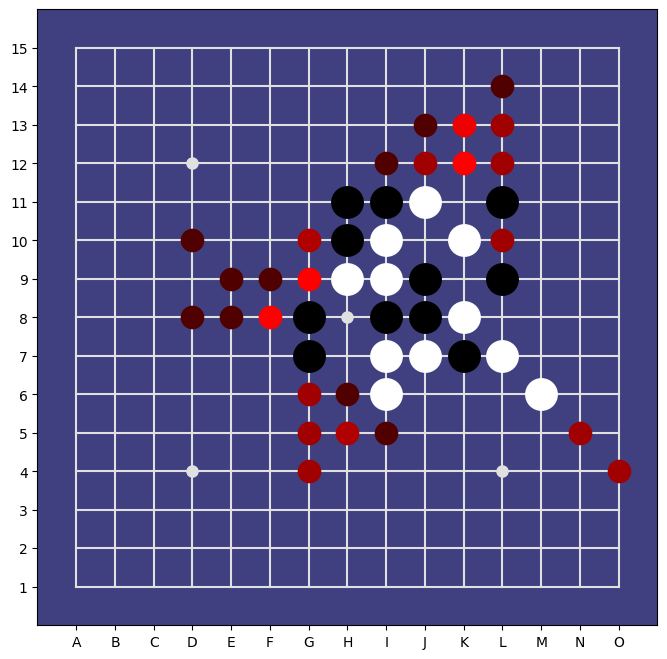

In [5]:
from aegomoku.utils import analyse_example
import random

analyse_example(BOARD_SIZE, examples[random.randint(0, len(examples))])

In [6]:
from aegomoku.gomoku_resnet import GomokuResnet

model = GomokuResnet(BOARD_SIZE, num_sensor_filters=1024, num_blocks=20)
model.compile()

/home/wgiersche/.local/share/virtualenvs/DeepGomoku-yQC4gx5q/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
2022-08-28 10:48:46.406837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-28 10:48:46.577918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-28 10:48:46.578

In [5]:
from aegomoku.trainer import Trainer
from aegomoku.game_data import create_dataset

N = 1000
trainer = Trainer(model)
ds = create_dataset(examples[:N])
trainer.train(ds, epochs_per_train=2000, report_every=10)

2022-08-21 08:13:18.019761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-21 08:13:18.284534: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch: 1, Training: p: 4.8271, v: 0.087788 - elapsed: 10.404s
Epoch: 11, Training: p: 4.1996, v: 0.081165 - elapsed: 16.728s
Epoch: 21, Training: p: 3.6518, v: 0.080202 - elapsed: 16.865s
Epoch: 31, Training: p: 3.3875, v: 0.079726 - elapsed: 17.463s
Epoch: 41, Training: p: 3.2309, v: 0.079328 - elapsed: 17.71s
Epoch: 51, Training: p: 3.1234, v: 0.078949 - elapsed: 17.562s
Epoch: 61, Training: p: 3.0384, v: 0.078391 - elapsed: 17.614s
Epoch: 71, Training: p: 2.9727, v: 0.077947 - elapsed: 17.13s
Epoch: 81, Training: p: 2.9181, v: 0.077263 - elapsed: 17.055s
Epoch: 91, Training: p: 2.8754, v: 0.07632 - elapsed: 17.353s
Epoch: 101, Training: p: 2.8432, v: 0.075111 - elapsed: 17.341s
Epoch: 111, Training: p: 2.8167, v: 0.074255 - elapsed: 17.429s
Epoch: 121, Training: p: 2.7926, v: 0.072312 - elapsed: 17.778s
Epoch: 131, Training: p: 2.7714, v: 0.070083 - elapsed: 17.391s
Epoch: 141, Training: p: 2.754, v: 0.068033 - elapsed: 17.21s
Epoch: 151, Training: p: 2.738, v: 0.065826 - elapsed: 1

KeyboardInterrupt: 

n=58547
Next to play: WHITE
Value from WHITE's point of view: -0.0940707389868678
Next to play: WHITE
Value from WHITE's point of view: -0.20878693461418152


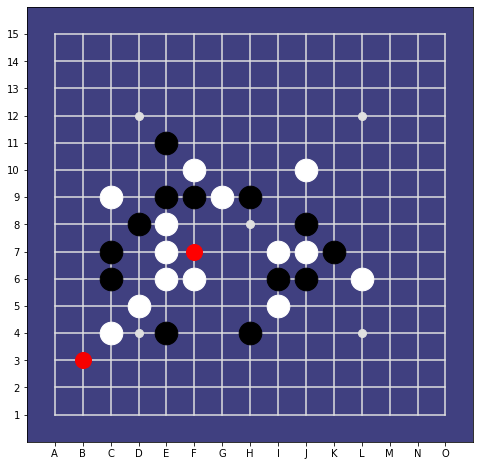

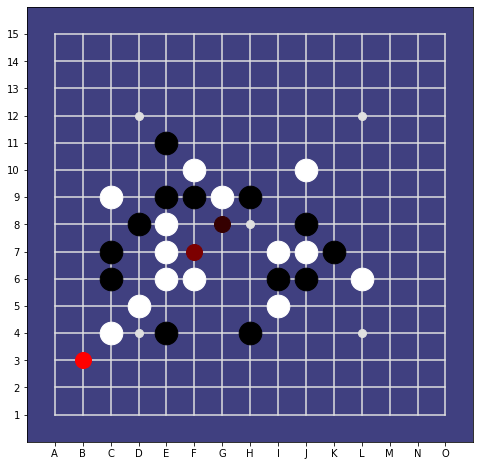

In [26]:
from aegomoku.utils import analyse_example
import numpy as np

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_, v_ = model(sample)
s, p, v = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"n={n}")
analyse_example(BOARD_SIZE, examples[n])
analyse_example(BOARD_SIZE, example)

In [28]:
model.save("models/first_model.model")

INFO:tensorflow:Assets written to: models/first_model.model/assets


INFO:tensorflow:Assets written to: models/first_model.model/assets


In [30]:
import tensorflow as tf
new_model = tf.keras.models.load_model("models/first_model.model")
# new_model.summary()

n=35306
Next to play: BLACK
Value from BLACK's point of view: -0.2311950922012329


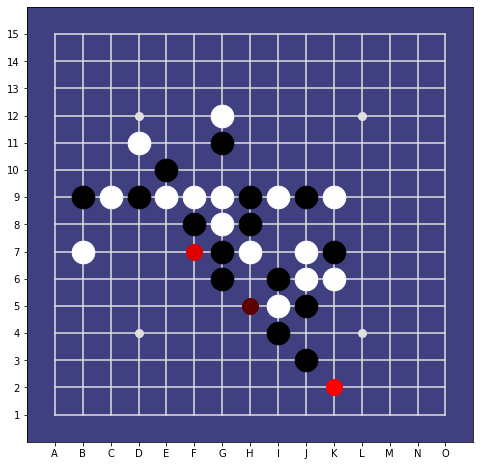

In [48]:
from aegomoku.utils import analyse_example
import numpy as np

n = random.randint(N, len(examples))
sample = np.expand_dims(examples[n][0], axis=0).astype(float)
p_, v_ = new_model(sample)
s, _, _ = examples[n]
example = (s, list(p_.numpy()), np.squeeze(v_))
print(f"n={n}")
analyse_example(BOARD_SIZE, example)